# Annotation Validator
## Provides a visual validation of the Annotations on a specific image

In [1]:
"""
23/03/21 09:44
Developed by Miles Danswan
"""

In [2]:
import os
import numpy as np
import json as js # parsing the json annotation files
import tkinter.filedialog as fd # open file dialog (retrieiving json files)
import matplotlib.pyplot as plt # working with skimage
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from skimage import io
from tkinter import * # displaying a native window

In [3]:
"""
CONSTANTS
"""
REGION_TYPES = ["circular", "rect", "polygon"]
REGION_TYPE_FILL_COLOURS = {REGION_TYPES[0] : "steel blue",
                            REGION_TYPES[1] : "OrangeRed2",
                            REGION_TYPES[2] : "red"}
REGION_TYPE_BORDER_COLOURS = {REGION_TYPES[0] : "blue2",
                              REGION_TYPES[1] : "OrangeRed4",
                              REGION_TYPES[2] : "friebrick3"}
REGION_BORDER_WIDTH = 2

In [4]:
"""
Creates an OpenFileName dialog for Retrieving a Filename
"""
def get_filename(root):
    return fd.askopenfilename(parent=root,filetypes=[("Annotation Files", "*.json"), ("All", "*.*")])

In [5]:
"""
Gets a Json Annotation file and attempts to find the corresponding Image file
"""
def get_annotation_set(root):
    
    json_filepath = None
    img_filepath = None
    
    # retrieve and split the filename of a json file
    fn = get_filename(root)
    json_filepath = fn
    path = os.path.split(fn)
    directory = path[0]
    filename = os.path.splitext(path[1])[0]
    
    # attempt to find the corresponding image file (recognised img files: png, jpg, jpeg)
    for fn in os.listdir(directory):
        if ((filename in fn) and (fn.endswith(".png") or fn.endswith(".jpg") or fn.endswith(".jpeg"))):
            img_filepath = directory + "/" + fn
            break
            
    return (json_filepath, img_filepath)

In [6]:
"""
Creates a basic TK Window with the provided name and width x height
"""
def create_window(name, w_x_h):
    main = Tk()
    main.title(name)
    main.geometry(w_x_h)
    main["bg"] = "black";
    return main

In [7]:
"""
Gets the Polygon Region Points and Rectangle Region Points from the provided Json file

TODO: Divide the following function into load_json_file and get_region_points
"""
def load_json_file(filepath):
    
    poly_region_points = []
    rect_region_points = []
    
    with open(filepath) as json:
        data = js.load(json)
        image_id = data["_via_image_id_list"][0]
        anno_data = data["_via_img_metadata"][image_id]
        for region in anno_data["regions"]:
            reg_shape_attr = region["shape_attributes"]
            if (reg_shape_attr["name"] == REGION_TYPES[2]):
                region_point = []
                for i in range(len(reg_shape_attr["all_points_x"])):
                    region_point.append((reg_shape_attr["all_points_x"][i], reg_shape_attr["all_points_y"][i]))
                poly_region_points.append(region_point)
            elif (reg_shape_attr["name"] == REGION_TYPES[1]):
                rect_region_points.append((reg_shape_attr["x"], reg_shape_attr["y"], reg_shape_attr["width"], reg_shape_attr["height"]))
                
    return (poly_region_points, rect_region_points)

In [8]:
"""
Defines a visual widget for each individual 'poly' and 'rect' region point
"""
def create_annotations(canvas, img_width, img_height, window_width, window_height, poly_region_points, rect_region_points):
    
    region_widgets = []
        
    for region in poly_region_points:
        p = canvas.create_polygon(region, tags=("region"), fill="", outline=REGION_TYPE_FILL_COLOURS[REGION_TYPES[2]], width=REGION_BORDER_WIDTH)
        region_widgets.append(p)
        
    for region in rect_region_points:
        p = canvas.create_rectangle(region[0], region[1], region[0] + region[2], region[1] + region[3], tags=("region"), outline=REGION_TYPE_FILL_COLOURS[REGION_TYPES[1]], width=REGION_BORDER_WIDTH)
        region_widgets.append(p)
        
    return region_widgets

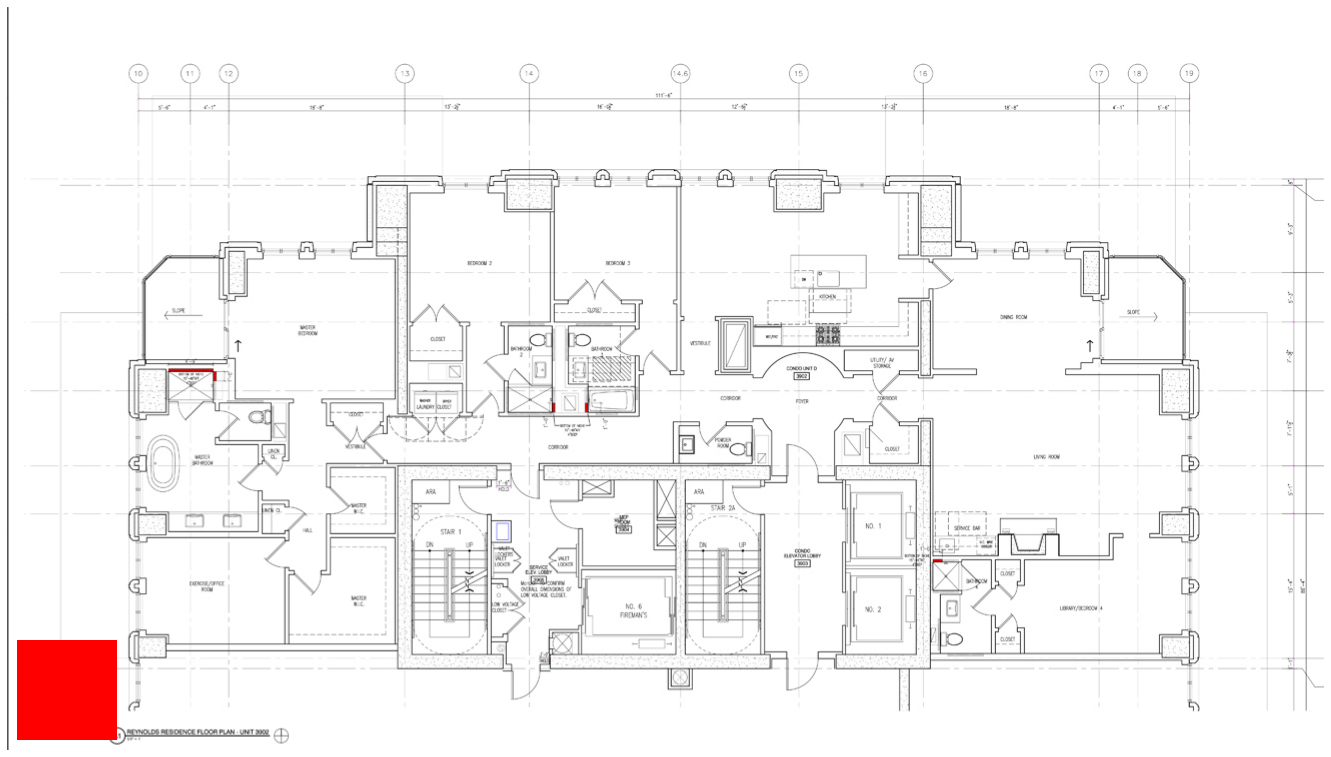

In [9]:
# Creating a Tkinter Window to host the Annotated Image and Annotations
main = create_window("Annotation Validator", "800x600")

# Attempt to retrieve the annotated image and corresponding json data
(json_path, img_path) = get_annotation_set(main)

# Load the json file
(poly_region_points, rect_region_points) = load_json_file(json_path);

# Load the image file
data = io.imread(img_path)

# Update window width and height
main.geometry(str(data.shape[1]) + "x" + str(data.shape[0]))

f = plt.figure(figsize=(1,1))
ax = f.add_subplot(111)
ax.add_patch(plt.Rectangle((10, 10), 100, 100, fc='r'))
ax.set_xlim([0, data.shape[1]])
ax.set_ylim([0, data.shape[0]])
f.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.axis("off")
img = plt.imshow(np.flipud(data), origin='lower')

# Creating a canvas for the Figure
fig_canvas = FigureCanvasTkAgg(f, master=main)
fig_canvas._tkcanvas.pack(expand=1, fill="both")

# Create Region Widget list for referring to later when removing
region_widgets = create_annotations(fig_canvas._tkcanvas, data.shape[1], data.shape[0], (data.shape[1], data.shape[1]), (data.shape[0], data.shape[0]), poly_region_points, rect_region_points)
fig_canvas._tkcanvas.tag_raise("region");

zoom_in_factor = 1.1
zoom_out_factor = 0.9
zoom_total = 1

def move_start(event):
    fig_canvas._tkcanvas.scan_mark(event.x, event.y)
    
def move_move(event):
    fig_canvas._tkcanvas.scan_dragto(event.x, event.y, gain=1)
    
def zoom_canvas(event):
    global main, f, fig_canvas, zoom_in_factor, zoom_out_factor, zoom_total
    
    # TODO: Fix the scaling between the image and the annotations
    
    if (event.delta > 0):
        fig_canvas._tkcanvas.scale("region", main.winfo_width() / 2, main.winfo_height() / 2, zoom_in_factor, zoom_in_factor)
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        dx = cur_xlim[1] - cur_xlim[0]
        dy = cur_ylim[1] - cur_ylim[0]
        ax.set_xlim([cur_xlim[0] + dx * .05, cur_xlim[1] - dx * .05])
        ax.set_ylim([cur_ylim[0] + dy * .05, cur_ylim[1] - dy * .05])
        fig_canvas.draw()
        zoom_total += 0.1
    elif (event.delta < 0 and zoom_total >= 0.5):
        fig_canvas._tkcanvas.scale("region", main.winfo_width() / 2, main.winfo_height() / 2, zoom_out_factor, zoom_out_factor)
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        dx = cur_xlim[1] - cur_xlim[0]
        dy = cur_ylim[1] - cur_ylim[0]
        ax.set_xlim([cur_xlim[0] - dx * .05, cur_xlim[1] + dx * .05])
        ax.set_ylim([cur_ylim[0] - dy * .05, cur_ylim[1] + dy * .05])
        fig_canvas.draw()
        zoom_total -= 0.1
        
    fig_canvas._tkcanvas.config(scrollregion=fig_canvas._tkcanvas.bbox("all"))
            
# Bind the canvas zoom and move commands
fig_canvas._tkcanvas.bind("<ButtonPress-1>", move_start)
fig_canvas._tkcanvas.bind("<B1-Motion>", move_move)
fig_canvas._tkcanvas.bind("<MouseWheel>", zoom_canvas)

# custom configuration function for the main canvas
def configure_canvas(event):
    global region_widgets, fig_canvas
        
    new_w, new_h = event.width, event.height
    xy = 0, 0, new_w - 1, new_h - 1

    # remove all old overlay components
    for widget in region_widgets:
        fig_canvas._tkcanvas.delete(widget);
    
    # redraw overlay components with new coordinates
    region_widgets = create_annotations(fig_canvas._tkcanvas, data.shape[1], data.shape[0], (fig_canvas._tkcanvas.winfo_width(), new_w), (fig_canvas._tkcanvas.winfo_height(), new_h), poly_region_points, rect_region_points)
    fig_canvas._tkcanvas.tag_raise("region");
        
main.bind("<Configure>", configure_canvas)

main.mainloop()